In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230120'
}

query = """
SELECT exp_group,
       user_id,
       countIf(action = 'view') views,
       countIf(action = 'like') likes,
       likes / views ctr
  FROM {db}.feed_actions
 WHERE toDate(time) BETWEEN '2022-12-25' AND '2022-12-31'
       AND exp_group IN (2, 3)
 GROUP BY exp_group,
          user_id
"""

df = pandahouse.read_clickhouse(query, connection=connection)

# Проверим, что все загрузилось как надо
print(df.head(5))

# Проверим, равномерно ли сгруппированы пользователи по группам
print(df.groupby('exp_group').count())

   exp_group  user_id  views  likes       ctr
0          3   115383     36     11  0.305556
1          3   123580     92     15  0.163043
2          2   131473    148     26  0.175676
3          2    23985     66     12  0.181818
4          2    24523    120     17  0.141667
           user_id  views  likes   ctr
exp_group                             
2             8480   8480   8480  8480
3             8569   8569   8569  8569


<h4>Пользователи примерно равномерно разбиты по группам. Проверим, как распределены ctr обеих групп визуально, используя гистограммы</h4>

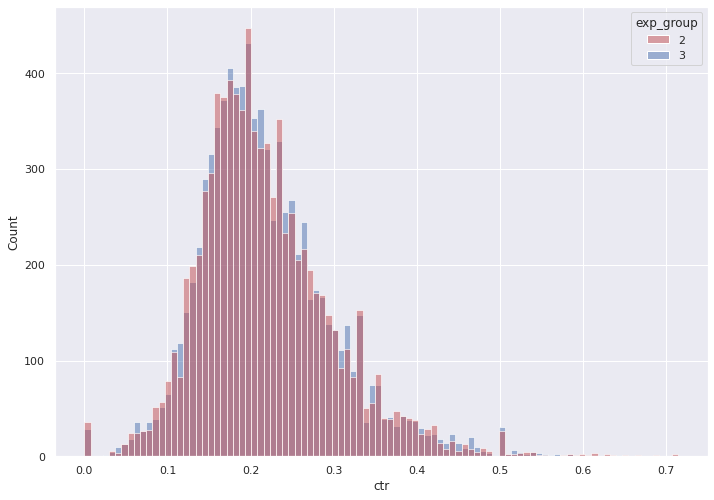

In [5]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False);

<h4>Гистограммы практически не отличаются друг от друга. Чтобы окончательно убедиться, что система сплитования работает корректно, сравним 10000 выборок без повторения в 500 юзеров из 2 и 3 экспериментальной группы, используя t-test.</h4>

In [6]:
p_values = pd.Series([stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace=False),
                                      df[df.exp_group == 3].ctr.sample(500, replace=False),
                                      equal_var=False)[1] for _ in range(10000)])


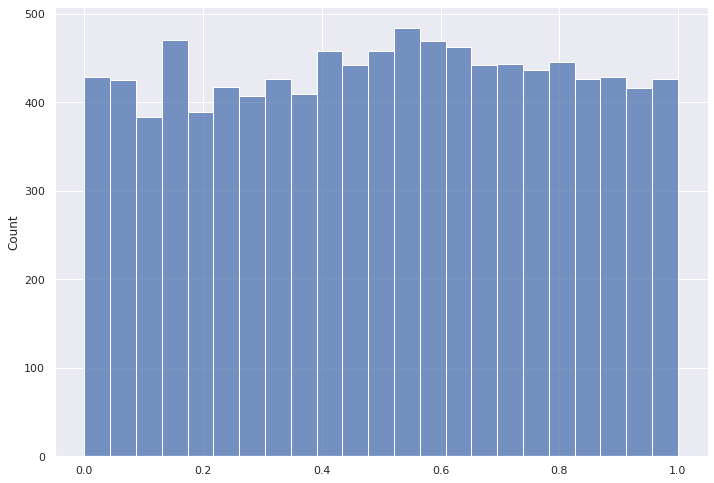

In [8]:
# Посмотрим, как распрделены p-values
sns.histplot(data=p_values);

In [9]:
print(f'''Процент p values, который оказался меньше либо равен 0.05 равен {p_values[p_values <= 0.05].count() / p_values.count():.2%}
Отсюда можно сделать вывод, что система сплитования работает корректно.''')

Процент p values, который оказался меньше либо равен 0.05 равен 4.89%
Отсюда можно сделать вывод, что система сплитования работает корректно.
